In [1]:
import os, sys, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from image_processing_tools import *
%matplotlib notebook

### Extract Images from PDF Library

In [2]:
excluded = [".ipynb_checkpoints", "unprocessed"]
extraction_progress = 1
make_png = False
names = []
for path, subdirs, files, in os.walk(pdf_directory):
    for file in files:
        try:
            names.append(file.split('.')[0])
            file_path = os.path.join(path,file)
            new_performer_data(base_name(file_path))
            ##split pdf file into pages
            if (make_png):
                pages = convert_from_path(file_path)
                page_num = 0
                for page in pages:
                    page.save(img_directory + base_name(file_path) + "/unprocessed/" + str(page_num) + ".png", 'PNG')
                    page_num += 1
                    extraction_progress = update_progress(extraction_progress, len(pages)*len(files), "extracting images from pdf files")
                page_num = 0
        except Exception as e:
            print (e)
            pass
print("extraction complete")

[Errno 17] File exists: 'data/img/Outi'
[Errno 17] File exists: 'data/img/Outi/unprocessed'
[Errno 17] File exists: 'data/img/Outi/red'
[Errno 17] File exists: 'data/img/Outi/cyan'
[Errno 17] File exists: 'data/img/Outi/red/scaled'
[Errno 17] File exists: 'data/img/Outi/cyan/scaled'
[Errno 17] File exists: 'data/img/Zjana'
[Errno 17] File exists: 'data/img/Zjana/unprocessed'
[Errno 17] File exists: 'data/img/Zjana/red'
[Errno 17] File exists: 'data/img/Zjana/cyan'
[Errno 17] File exists: 'data/img/Zjana/red/scaled'
[Errno 17] File exists: 'data/img/Zjana/cyan/scaled'
[Errno 17] File exists: 'data/img/Kadri'
[Errno 17] File exists: 'data/img/Kadri/unprocessed'
[Errno 17] File exists: 'data/img/Kadri/red'
[Errno 17] File exists: 'data/img/Kadri/cyan'
[Errno 17] File exists: 'data/img/Kadri/red/scaled'
[Errno 17] File exists: 'data/img/Kadri/cyan/scaled'
[Errno 17] File exists: 'data/img/Simona'
[Errno 17] File exists: 'data/img/Simona/unprocessed'
[Errno 17] File exists: 'data/img/Simona

### Crop images around human figure & extract colour channels

In [15]:
excluded = [".ipynb_checkpoints", "unprocessed", "cyan", "red", "scaled"]
names = []

# list of colour boundaries
boundaries = [
	([70, 0, 100, 0], [100, 255,255, 255]),
	([0, 50, 0, 0], [70, 255,255, 255])
]

for path, subdirs, files, in os.walk(img_directory):
    for subdir in subdirs:
        if any(ex in subdir for ex in excluded):
            continue
        names.append(subdir)
        print("Reading from foler: " + subdir)
        for path, subdirs, files, in os.walk(img_directory+subdir+"/unprocessed"):
            for file in files:
                drawings = []
                file_path = os.path.join(path,file)
                img = cv2.imread(file_path)
                #fill space around manikin, in top-left corner and top
                img = add_whitespace(img, 0, 0, 700, 450)
                img = add_whitespace(img, 0, 0, img.shape[0],200)
                #crop around manikin
                cropped_img = crop_heatmap(img, 0)
                file_path = os.path.join(os.path.normpath(os.path.join(path, os.pardir)),file)
                cv2.imwrite(file_path, cropped_img)
                
                ## convert to hsv
                hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
                # loop over the boundaries
                for lower_bound, upper_bound in boundaries:
                    drawings.append(extract_drawing(cropped_img, hsv, tuple(lower_bound), tuple(upper_bound)))
                ## separate masking of cyan and red + ## filter bodily outline
                file_path = os.path.normpath(os.path.join(file_path, os.pardir))
                cyan_drawing, red_drawing = drawings
                cv2.imwrite(file_path+"/cyan/scaled/"+file, compress(cyan_drawing, (112, 112)))
                cv2.imwrite(file_path+"/red/scaled/"+file, compress(red_drawing, (112, 112)))

In [79]:
import os
import numpy as np
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
ia.seed(4)
%matplotlib inline

excluded = set([".mayaSwatches", ".ipynb_checkpoints", "unprocessed", "cyan", "red", "scaled"])
drawings = []

for path, subdirs, files, in os.walk(img_directory, topdown=True):
    for subdir in [s for s in subdirs if s not in excluded]:
        print("Reading from foler: " + subdir)
        for file in os.listdir(img_directory+subdir):
            if file.endswith(".png"):
                file_path = os.path.join(img_directory+subdir,file)
                drawings.append(imageio.imread(file_path))

Reading from foler: Outi
Reading from foler: Zjana
Reading from foler: Simona
Reading from foler: Juan
Reading from foler: Ella
Reading from foler: Eleonora
Reading from foler: Hanna
Reading from foler: Einav
Reading from foler: Kadri
Reading from foler: Sylvia


In [80]:
seq = []

# Geometric distortion effect
seq.append(iaa.Sequential([
    iaa.ElasticTransformation(alpha=60, sigma=7), 
], random_order=True))

seq.append(iaa.Sequential([
    iaa.ElasticTransformation(alpha=100, sigma=7),
], random_order=True))

seq.append(iaa.Sequential([
    iaa.ElasticTransformation(alpha=60, sigma=4), 
], random_order=True))

seq.append(iaa.Sequential([
    iaa.ElasticTransformation(alpha=100, sigma=4),
], random_order=True))

In [ ]:
drawings = drawings[:]
# augment them as one batch
images_aug = []
for i in range(len(drawings)):
    images_aug = []
    for j in range(len(seq)):
        images_aug.append(seq[j].augment_images(drawings))
images_aug = np.array(images_aug)
images_aug = images_aug.transpose()
print(np.shape(images_aug))

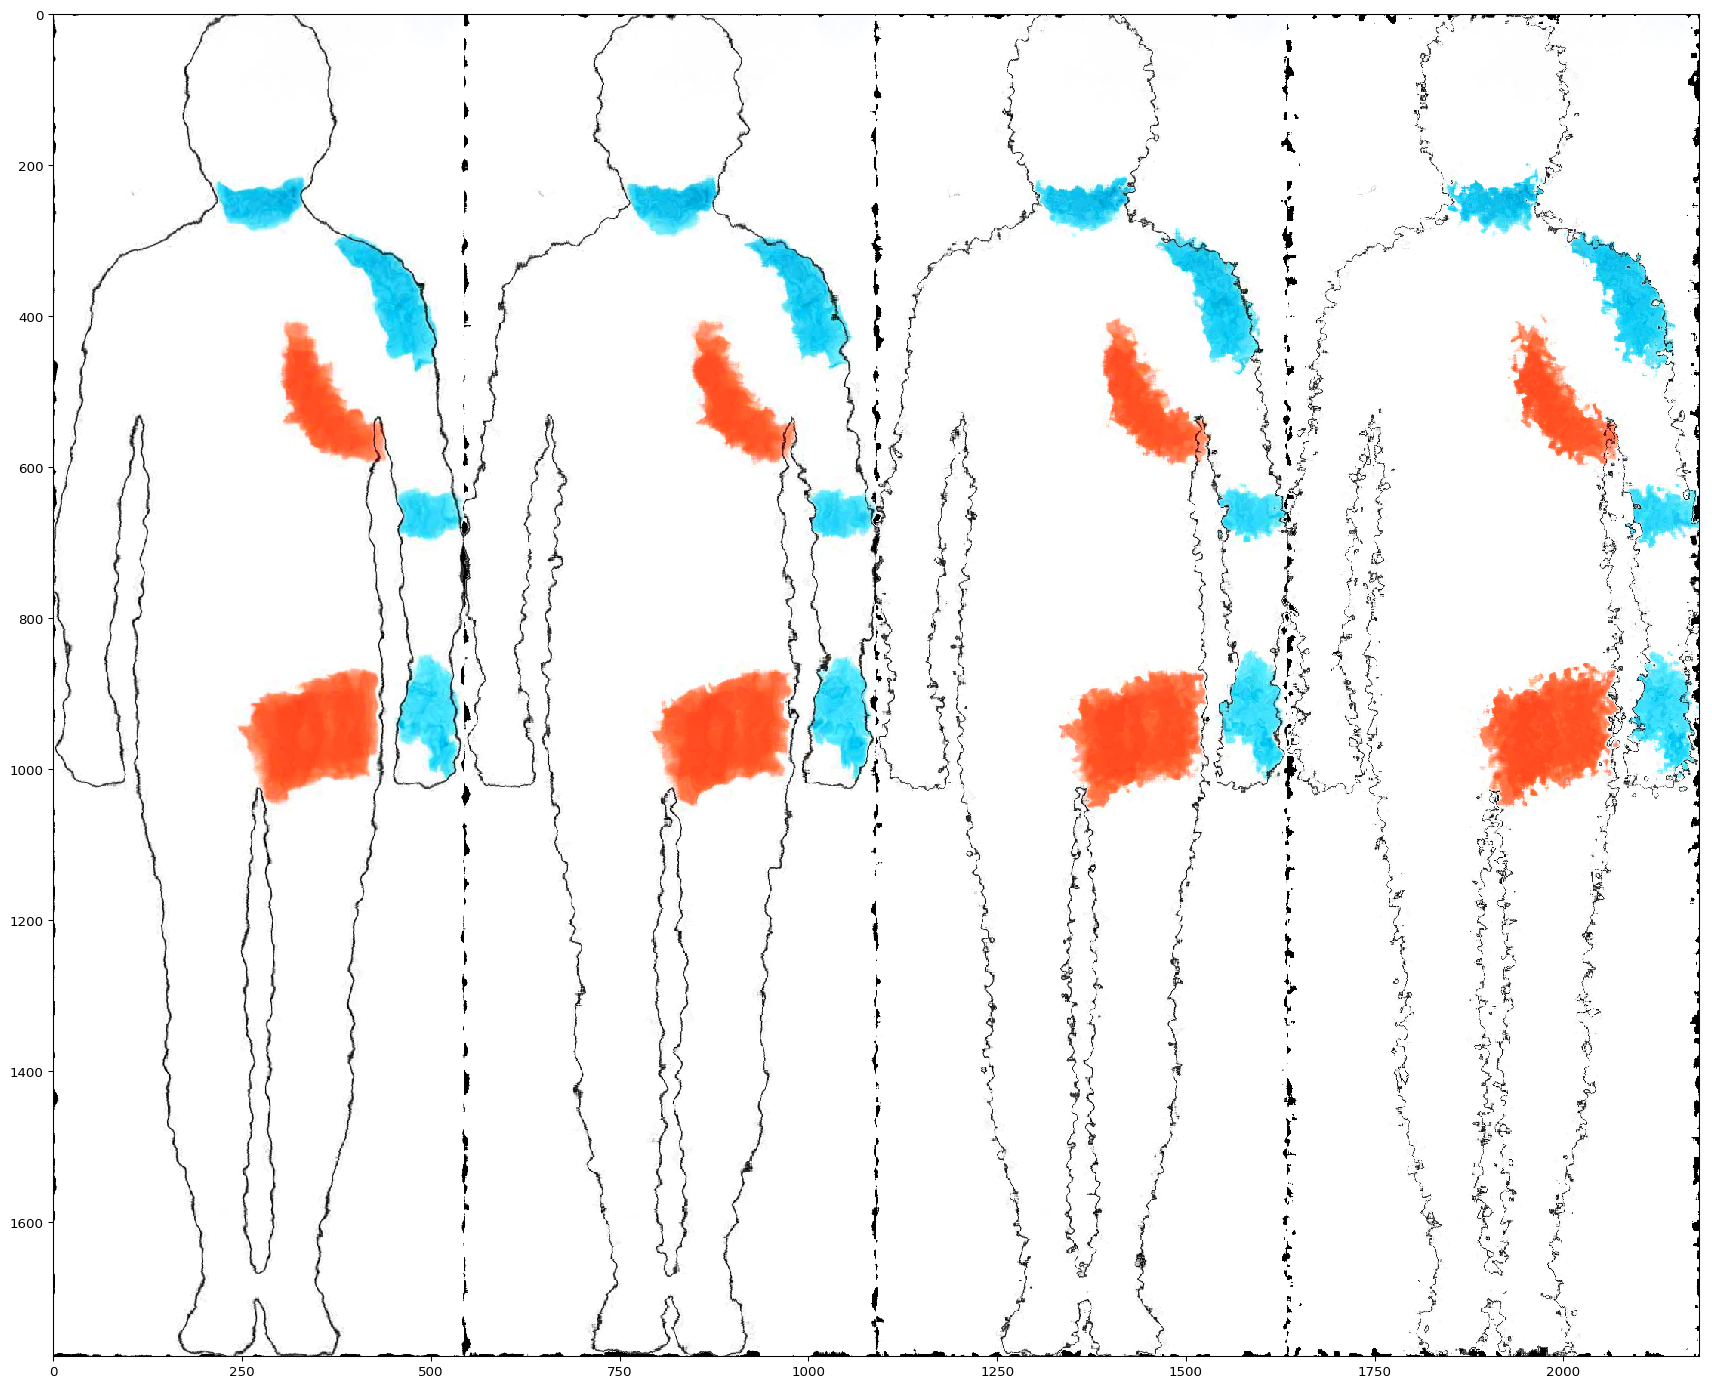

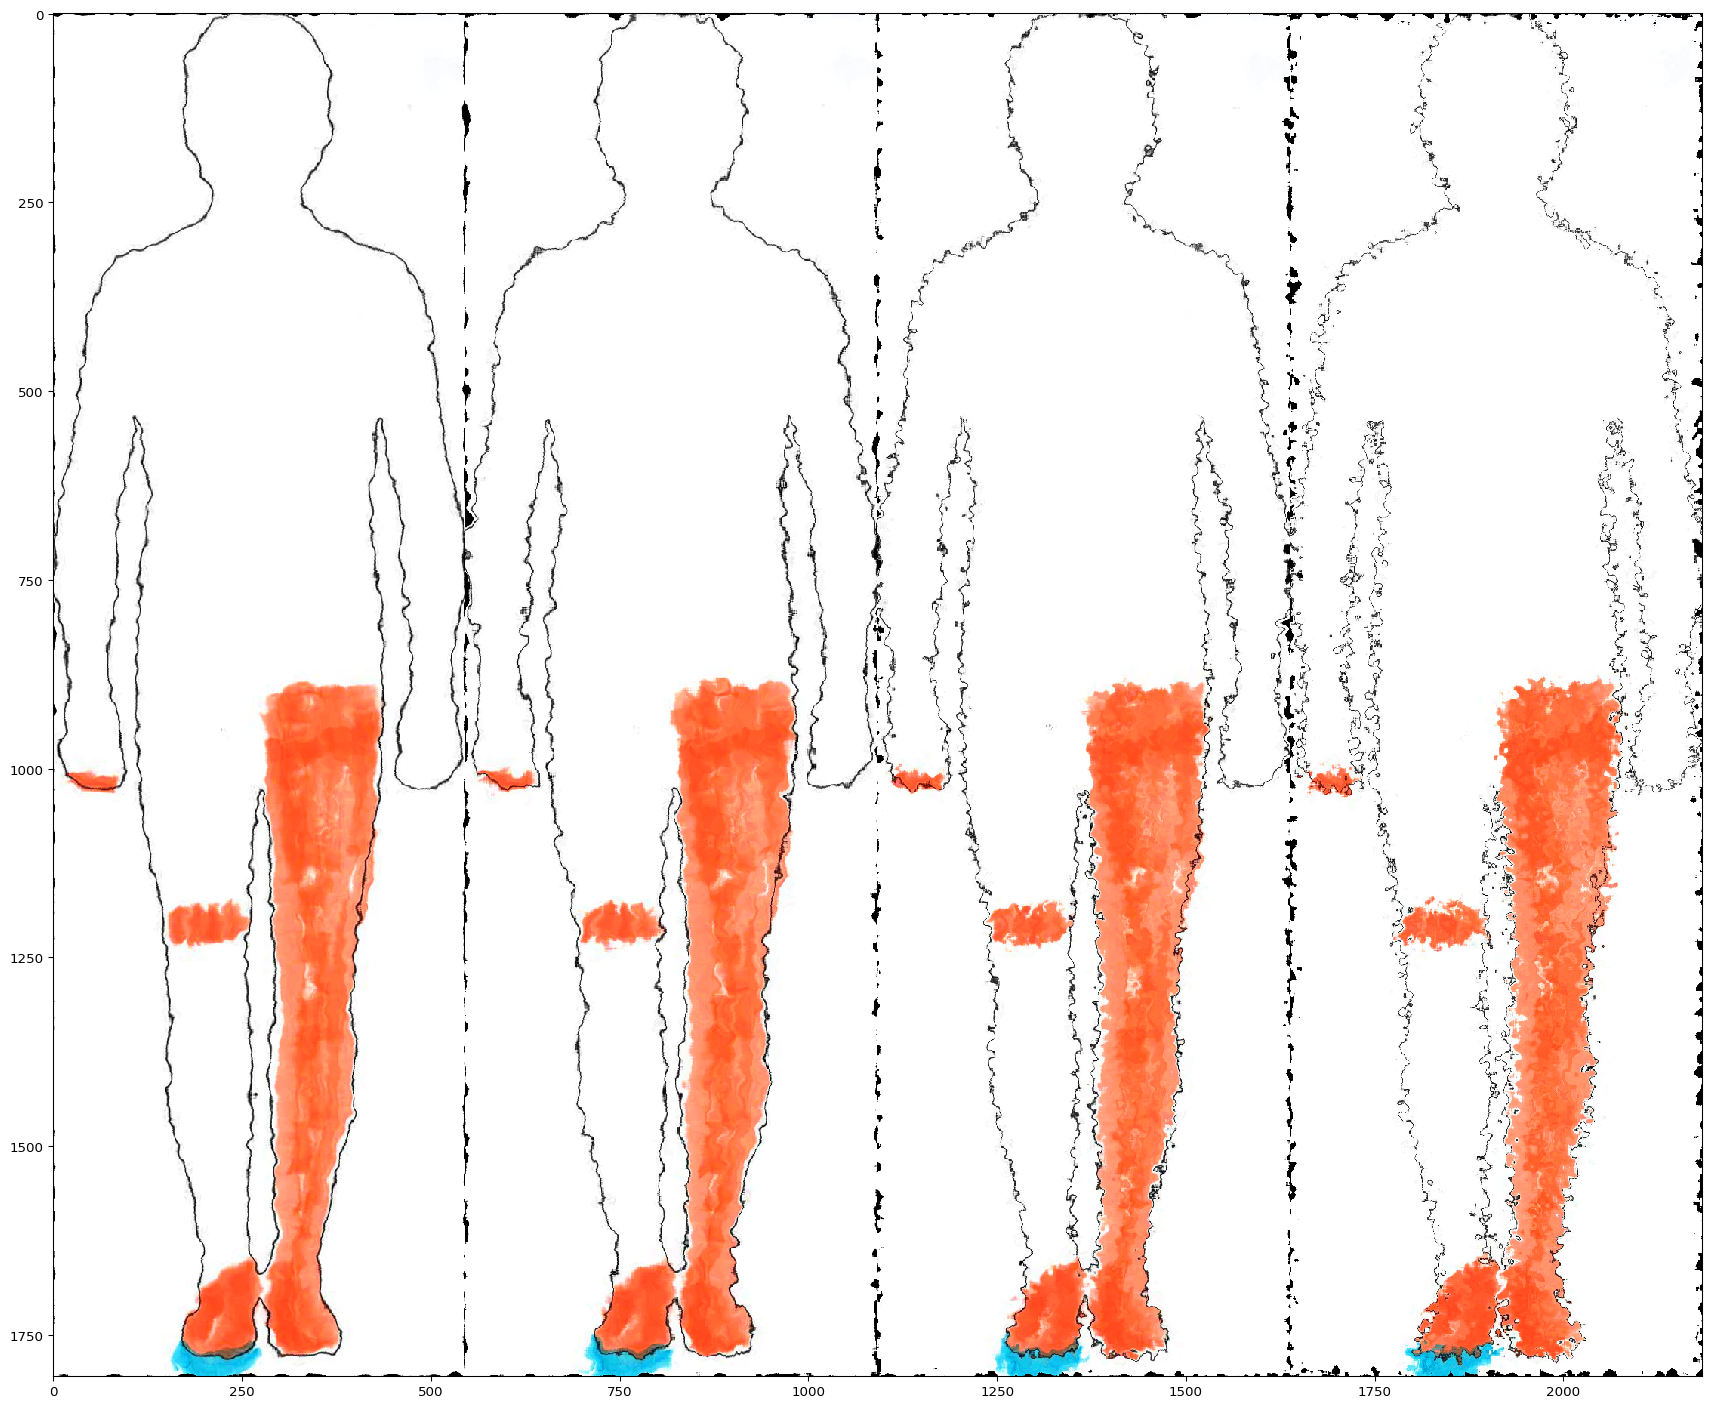

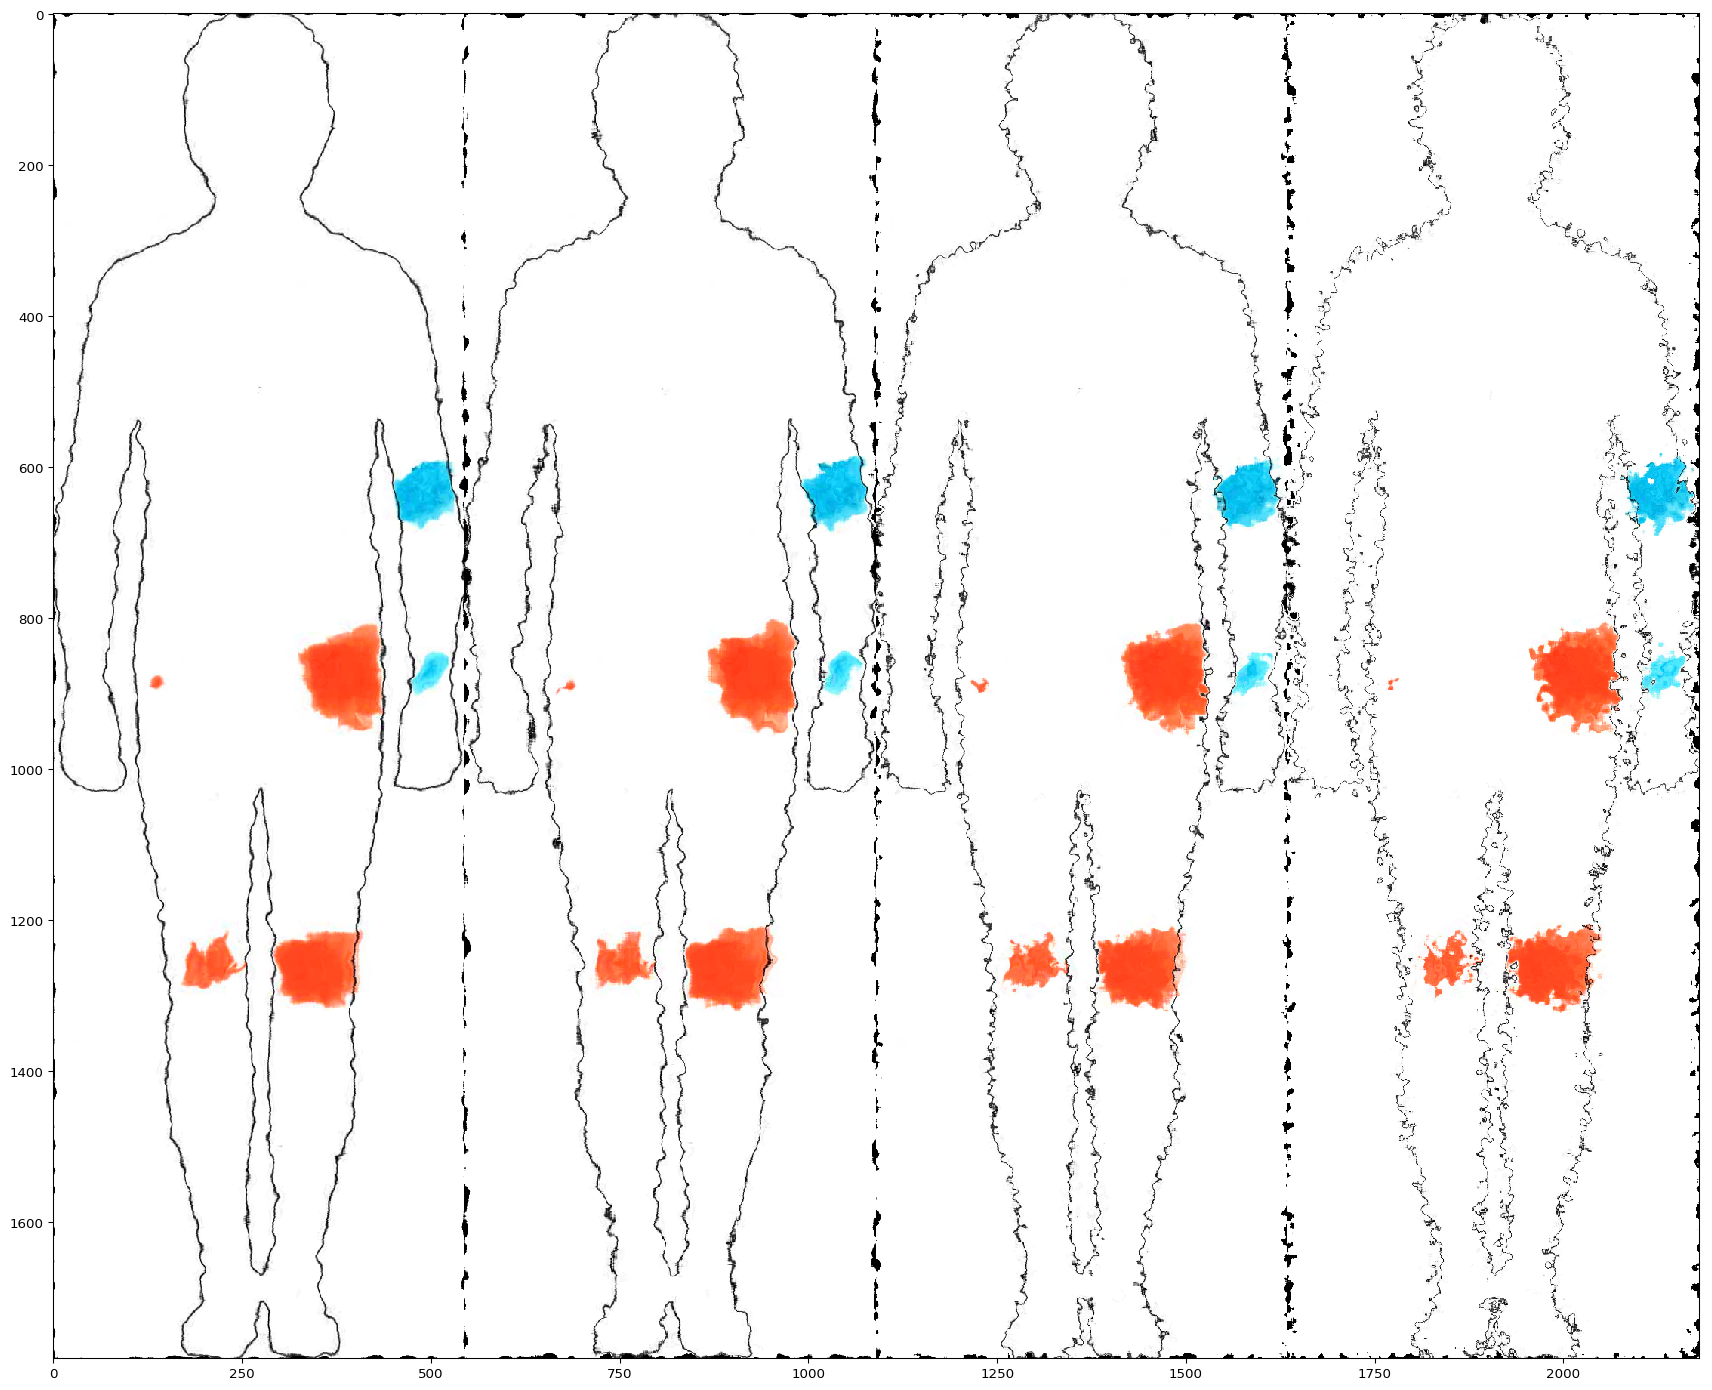

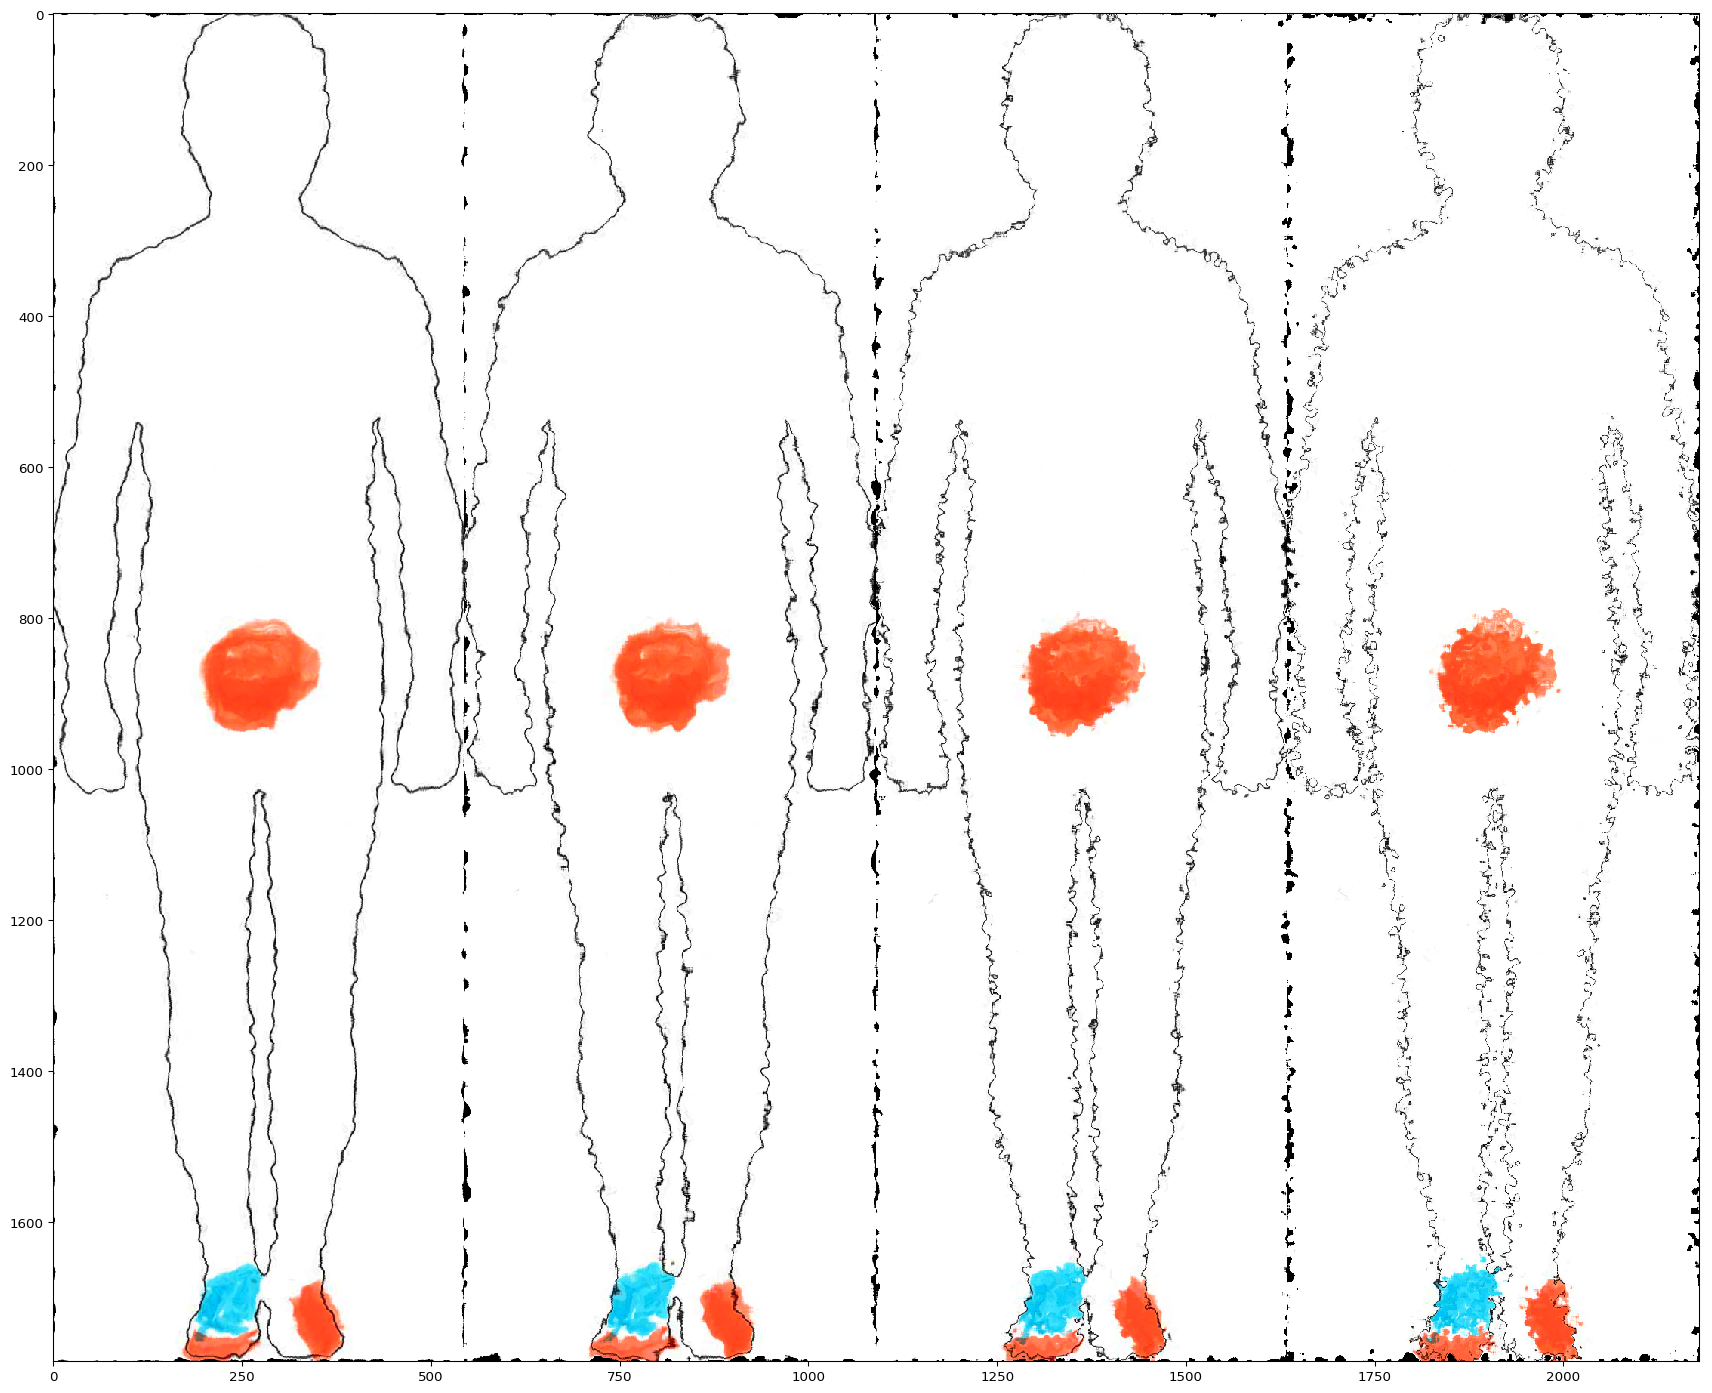

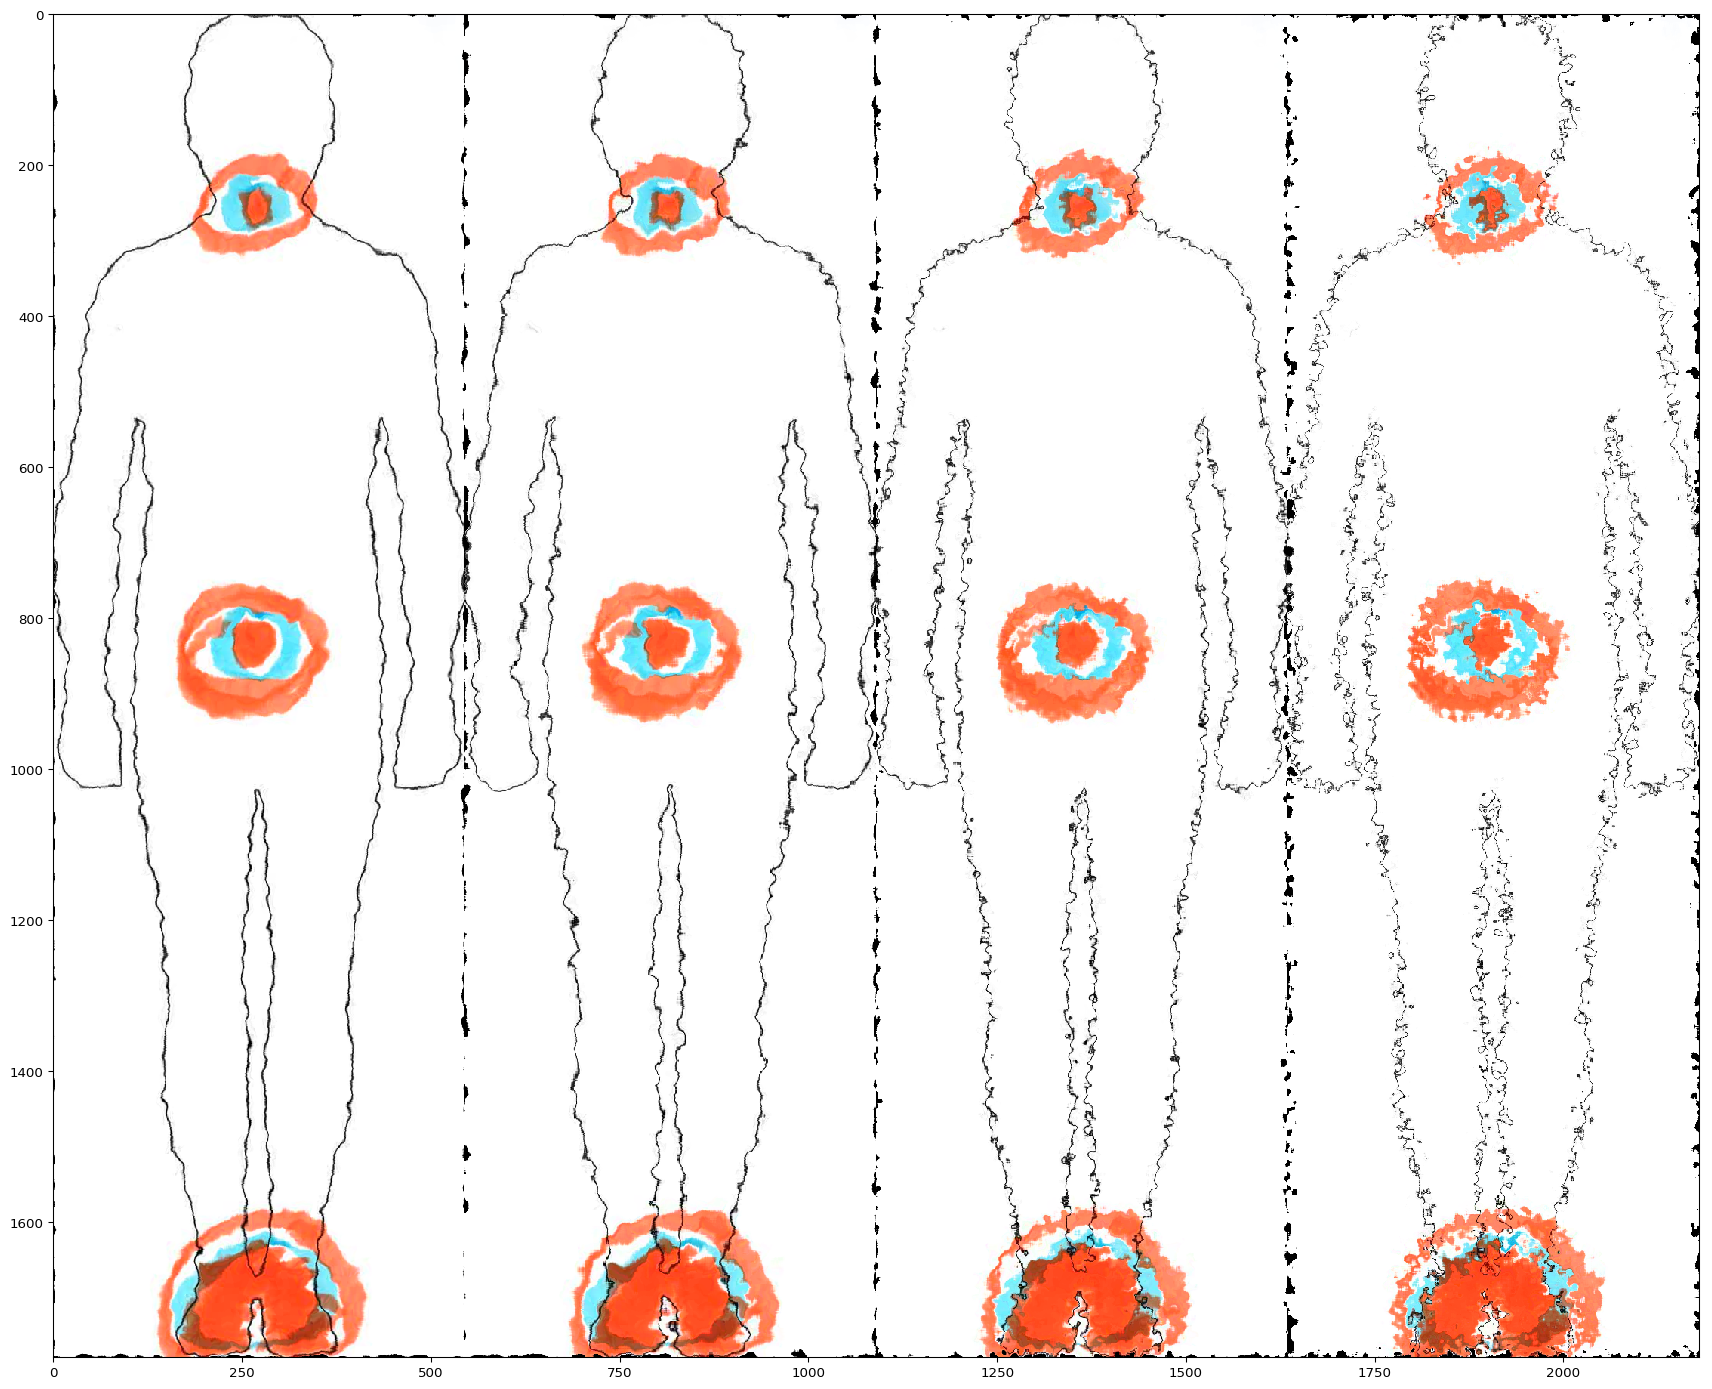

In [76]:
for i in range(np.shape(images_aug)[0]):  
    ia.imshow(np.hstack(images_aug[i]))

In [69]:
images = [cv2.imread(file) for file in glob.glob('data/img/Juan/*png')]
for img in images:
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(img)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    cv2.imwrite("test.png", dst)

In [67]:
drawings = drawings[:5]
# augment them as one batch
images_aug = []
for i in range(len(drawings)):
    images_aug = []
    for j in range(len(seq)):
        images_aug.append(seq[j].augment_images(drawings))
images_aug = np.array(images_aug)
images_aug = images_aug.transpose()
print(np.shape(images_aug))

(0,)


In [8]:
filelist=glob.glob("sketch_dataset/*.png")
for file in filelist:
    os.remove(file)

In [20]:
from imutils import paths
def create_gif(inputPath, outputPath, delay, finalDelay, loop):
    # grab all image paths in the input directory
    imagePaths = sorted(list(paths.list_images(inputPath)))
    print(imagePaths)

    # remove the last image path in the list
    lastPath = imagePaths[-1]
    imagePaths = imagePaths[:-1]

    # construct the image magick 'convert' command that will be used
    # generate our output GIF, giving a larger delay to the final
    # frame (if so desired)
    cmd = "convert -delay {} {} -delay {} {} -loop {} {}".format(
        delay, " ".join(imagePaths), finalDelay, lastPath, loop,
        outputPath)
    os.system(cmd)

create_gif("../output/tests/result3", "../output/new.gif", 0, 0, 0)

['../output/tests/result3/step_0.png', '../output/tests/result3/step_1.png', '../output/tests/result3/step_10.png', '../output/tests/result3/step_11.png', '../output/tests/result3/step_12.png', '../output/tests/result3/step_13.png', '../output/tests/result3/step_14.png', '../output/tests/result3/step_15.png', '../output/tests/result3/step_16.png', '../output/tests/result3/step_17.png', '../output/tests/result3/step_18.png', '../output/tests/result3/step_19.png', '../output/tests/result3/step_2.png', '../output/tests/result3/step_20.png', '../output/tests/result3/step_21.png', '../output/tests/result3/step_22.png', '../output/tests/result3/step_23.png', '../output/tests/result3/step_24.png', '../output/tests/result3/step_3.png', '../output/tests/result3/step_4.png', '../output/tests/result3/step_5.png', '../output/tests/result3/step_6.png', '../output/tests/result3/step_7.png', '../output/tests/result3/step_8.png', '../output/tests/result3/step_9.png']


True